# Simple vs Normal DPLL

This notebook compares Simplified and Normal versions of DPLL, using the same graph model. The Simplified DPLL is previously used in our experiments version of DPLL. The Normalized DPLL (aka Normal DPLL) is DPLL with two heuristics: unit propagation (removing unit clauses) and pure literal elimination.

It is visible that using DPLL with those heuristics speeds up DPLL by orders of magnitude: see results at the end of notebook, e.g. print_all(10, 500, 30, light=True).

(notebook was basde on "fussy cut dpll comparison neurosat on SR var 50 - very short.ipynb" )

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 50

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [90]:
LIMIT_RUNS = 1000

In [66]:
def make_simplified(cls):
    class SimplifiedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None

            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)

            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    SimplifiedDPLL.__name__ = "Simplified{}".format(cls.__name__)
    return SimplifiedDPLL

def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf

def make_normalized(cls):
    class NormalizedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None
            
            cnf = shorten_cnf(cnf)
            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)

            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    NormalizedDPLL.__name__ = "Normalized{}".format(cls.__name__)
    return NormalizedDPLL

In [6]:
np.set_printoptions(precision=2, suppress=True)

In [10]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
META_FILE = "../models/neuropol-18-09-18-002956/model-7268352.meta"
# META_FILE = os.path.expandvars("$HOME/prometheus-models/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945.meta")
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from ../models/neuropol-18-09-18-002956/model-7268352


In [11]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [9]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [14]:
LEVEL = 20

In [15]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [16]:
np.set_printoptions(precision=3, suppress=True)

In [13]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [61]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        # print("Chosen neural", best_svar)
        return best_svar

In [62]:
SimplifiedGraphBasedDPLL = make_simplified(GraphBasedDPLL)
NormalizedGraphBasedDPLL = make_normalized(GraphBasedDPLL)

In [67]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps, errors

In [24]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [50]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, SimplifiedGraphBasedDPLL)
    compute_and_print_steps(sats, NormalizedGraphBasedDPLL)
    logfile.flush()


  0%|          | 0/30 [00:00<?, ?it/s]

We have generated 30 formulas



100%|██████████| 30/30 [01:36<00:00,  3.22s/it]


Within 1000 steps solved 19 problems out of 30
#Sats: 19; avg step: 69.63; stdev step: 158.47; avg error: 0.26; stdev error: 0.44


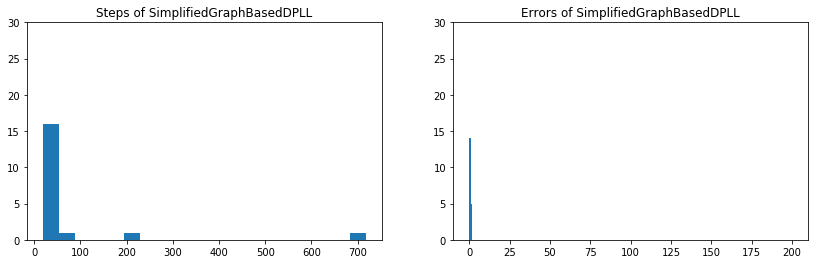

100%|██████████| 30/30 [00:12<00:00,  2.55it/s]


Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 31.17; stdev step: 37.72; avg error: 0.57; stdev error: 0.80


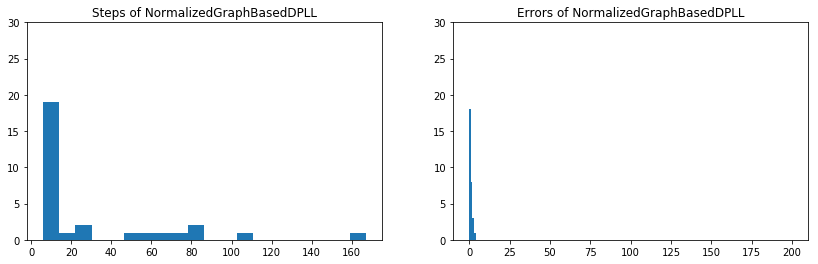

In [91]:
print_all(30, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:33<00:00,  4.41s/it]


Within 1000 steps solved 6 problems out of 10
#Sats: 6; avg step: 28.50; stdev step: 16.78; avg error: 0.33; stdev error: 0.47


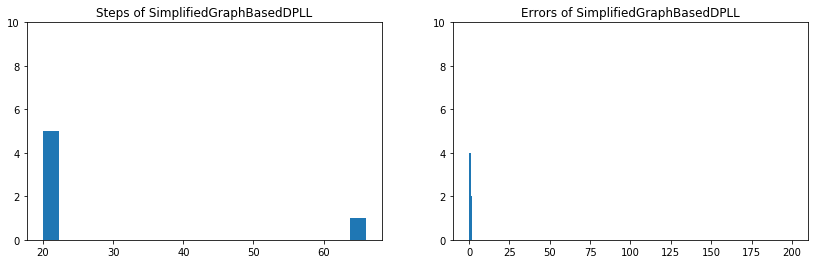

100%|██████████| 10/10 [00:03<00:00,  2.31it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 23.10; stdev step: 23.34; avg error: 0.60; stdev error: 0.66


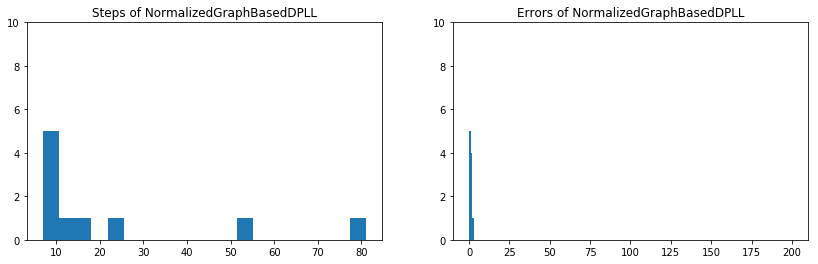

In [92]:
print_all(10, 200, 20)

 10%|█         | 1/10 [00:00<00:01,  7.58it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  7.66it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 10.90; stdev step: 0.30; avg error: 0.00; stdev error: 0.00


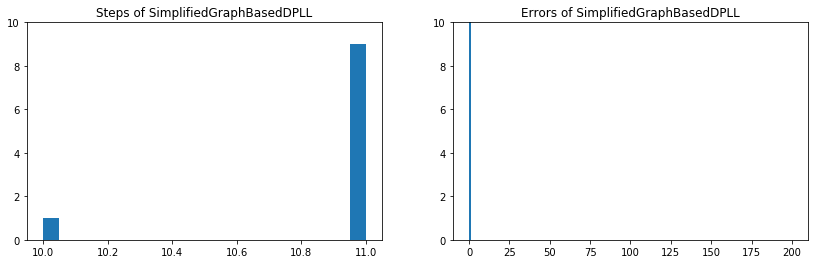

100%|██████████| 10/10 [00:00<00:00, 11.69it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 6.20; stdev step: 1.40; avg error: 0.00; stdev error: 0.00


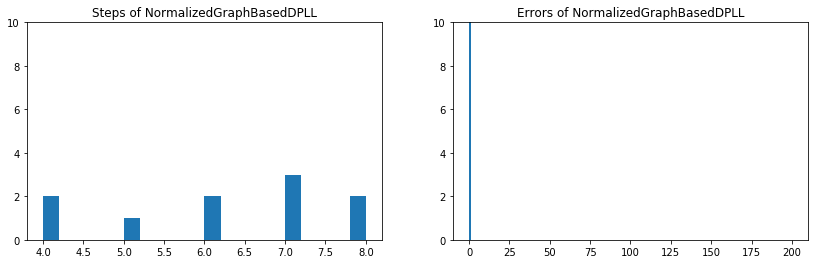

In [93]:
print_all(10, 200, 10)

 10%|█         | 1/10 [00:00<00:01,  5.34it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 12.80; stdev step: 0.40; avg error: 0.00; stdev error: 0.00


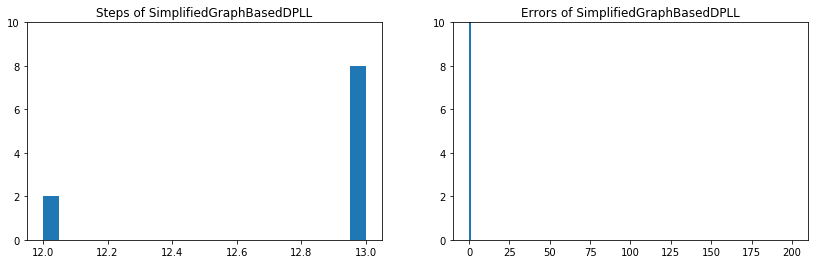

100%|██████████| 10/10 [00:01<00:00,  9.81it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 6.10; stdev step: 1.04; avg error: 0.00; stdev error: 0.00


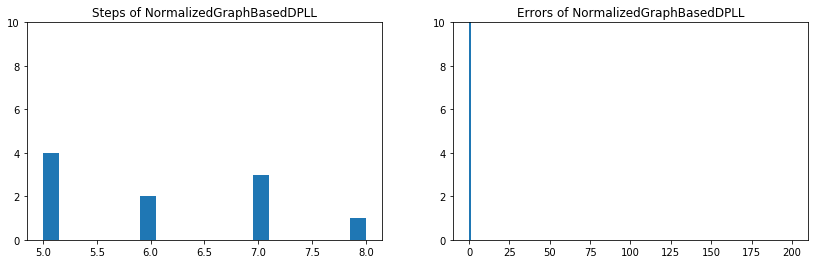

In [94]:
print_all(10, 200, 12)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:07<00:00,  2.97it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 101.90; stdev step: 261.70; avg error: 0.20; stdev error: 0.60


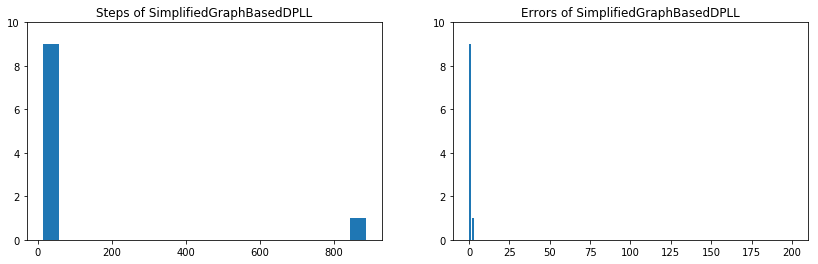

100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 11.60; stdev step: 14.16; avg error: 0.20; stdev error: 0.60


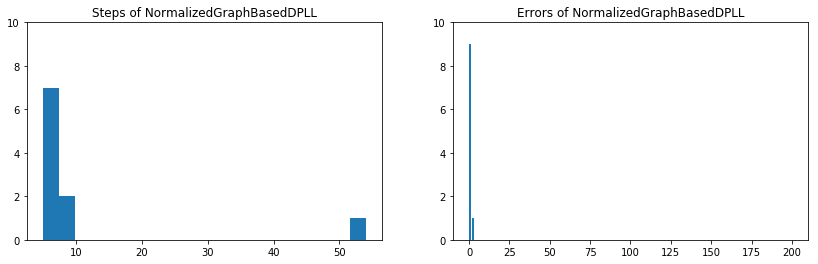

In [95]:
print_all(10, 200, 14)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:09<00:00,  1.79it/s]


Within 1000 steps solved 9 problems out of 10
#Sats: 9; avg step: 16.89; stdev step: 0.31; avg error: 0.00; stdev error: 0.00


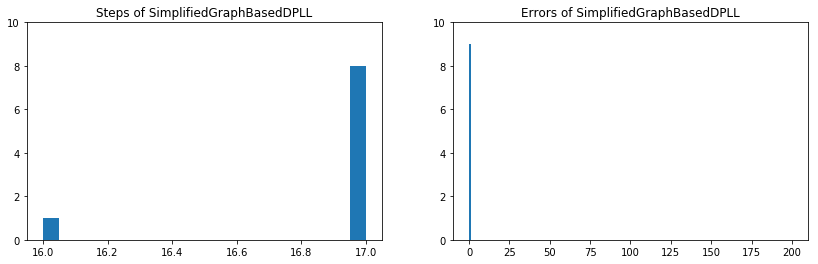

100%|██████████| 10/10 [00:02<00:00,  5.97it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 10.80; stdev step: 9.17; avg error: 0.10; stdev error: 0.30


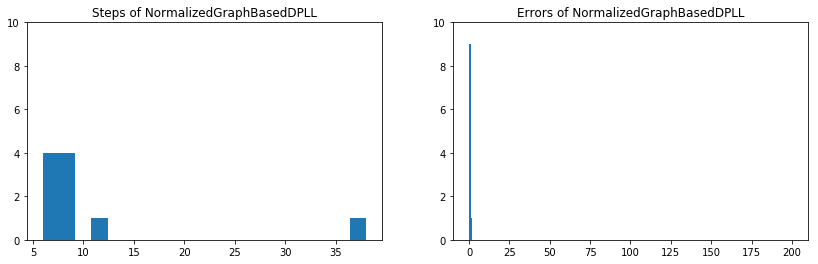

In [96]:
print_all(10, 200, 16)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:40<00:00,  5.26s/it]


Within 1000 steps solved 6 problems out of 10
#Sats: 6; avg step: 158.17; stdev step: 312.08; avg error: 0.17; stdev error: 0.37


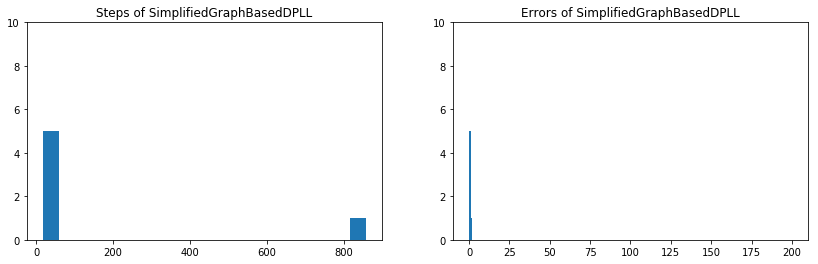

100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 24.50; stdev step: 16.55; avg error: 0.70; stdev error: 0.90


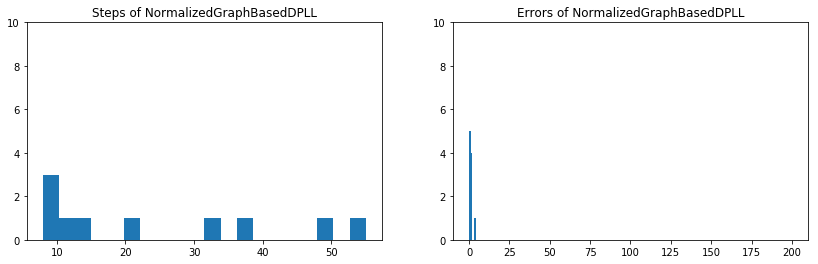

In [97]:
print_all(10, 200, 18)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:33<00:00,  4.41s/it]


Within 1000 steps solved 6 problems out of 10
#Sats: 6; avg step: 28.50; stdev step: 16.78; avg error: 0.33; stdev error: 0.47


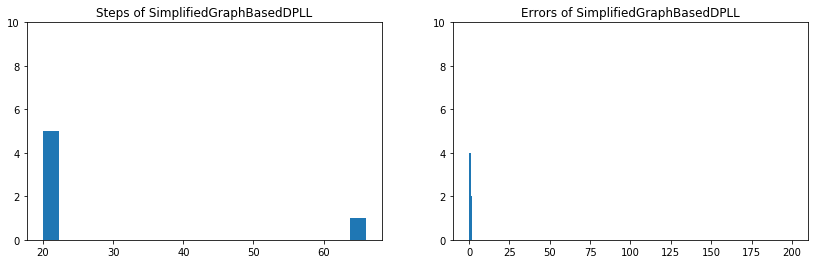

100%|██████████| 10/10 [00:03<00:00,  2.29it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 23.10; stdev step: 23.34; avg error: 0.60; stdev error: 0.66


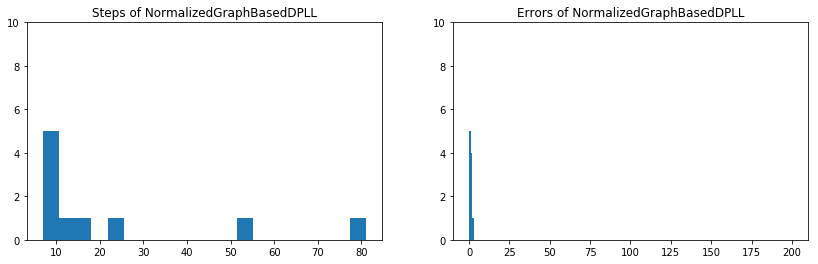

In [98]:
print_all(10, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:35<00:00,  1.66s/it]


Within 1000 steps solved 6 problems out of 10
#Sats: 6; avg step: 26.00; stdev step: 0.00; avg error: 0.00; stdev error: 0.00


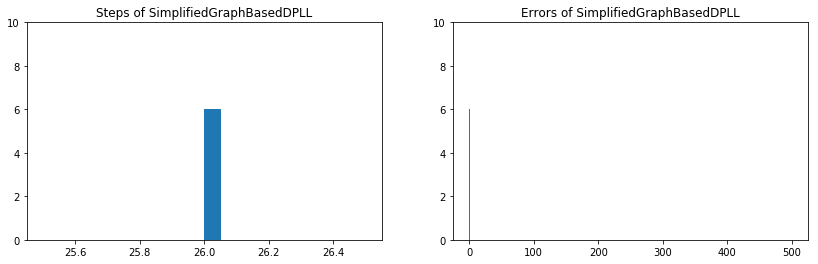

100%|██████████| 10/10 [00:14<00:00,  1.13it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 76.20; stdev step: 115.77; avg error: 0.70; stdev error: 0.90


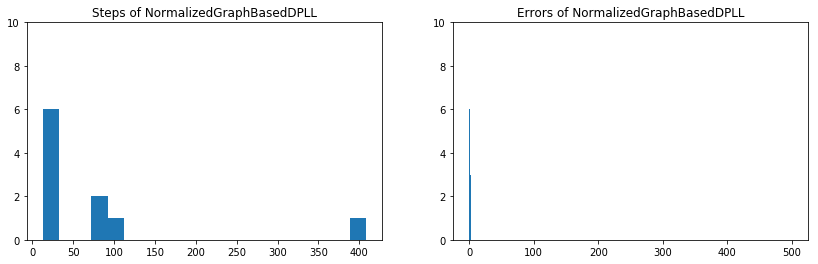

In [99]:
print_all(10, 500, 25, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [01:21<00:00,  5.95s/it]


Within 1000 steps solved 2 problems out of 10
#Sats: 2; avg step: 31.00; stdev step: 0.00; avg error: 0.00; stdev error: 0.00


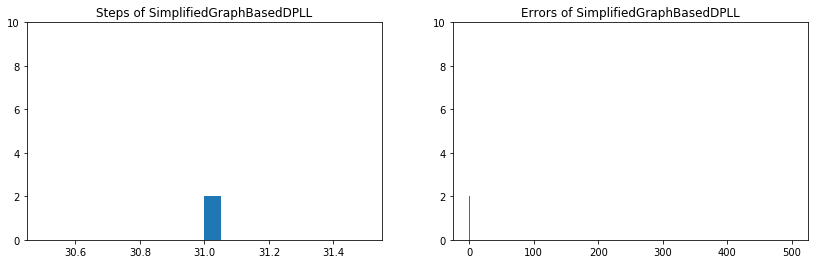

100%|██████████| 10/10 [00:26<00:00,  1.99s/it]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 150.50; stdev step: 125.76; avg error: 1.10; stdev error: 0.54


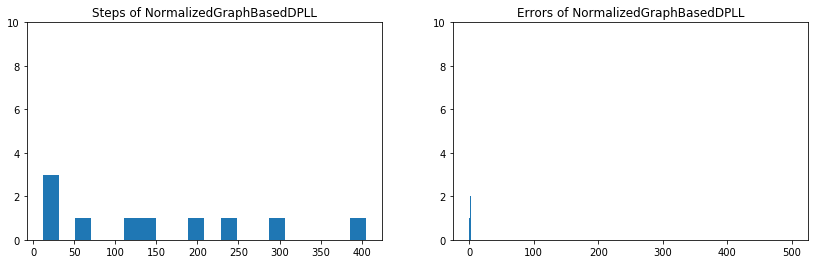

In [100]:
print_all(10, 500, 30, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [01:10<00:00,  5.22s/it]


Within 1000 steps solved 4 problems out of 10
#Sats: 4; avg step: 40.25; stdev step: 0.43; avg error: 0.00; stdev error: 0.00


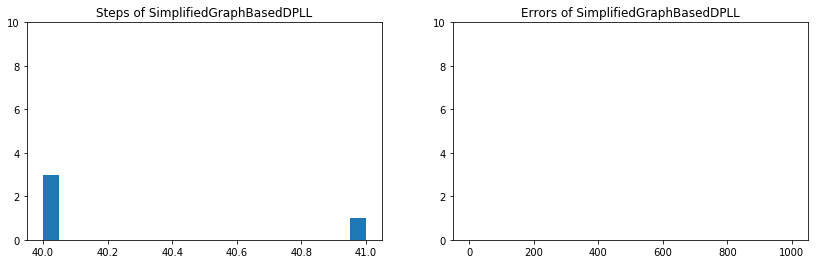

100%|██████████| 10/10 [01:30<00:00,  7.87s/it]


Within 1000 steps solved 6 problems out of 10
#Sats: 6; avg step: 64.50; stdev step: 109.80; avg error: 0.17; stdev error: 0.37


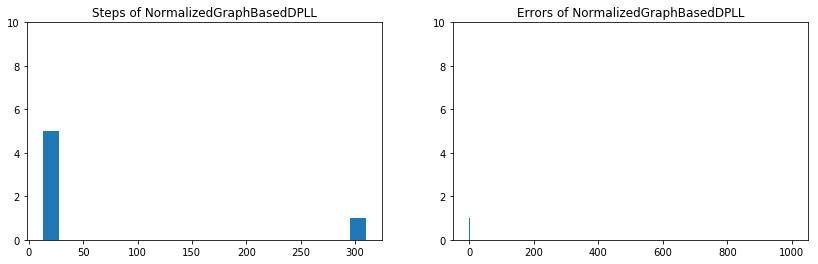

In [101]:
print_all(10, 1000, 40, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [01:45<00:00,  7.91s/it]


Within 1000 steps solved 3 problems out of 10
#Sats: 3; avg step: 50.00; stdev step: 0.82; avg error: 0.00; stdev error: 0.00


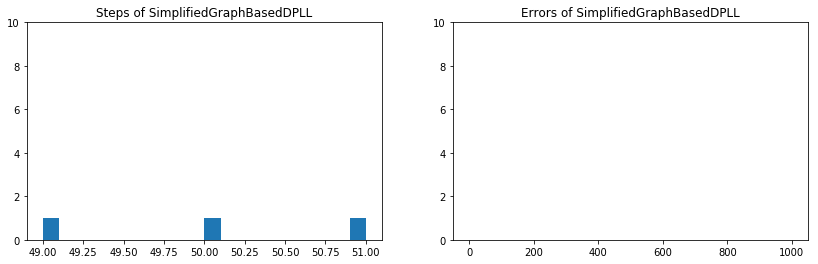

100%|██████████| 10/10 [01:50<00:00, 11.33s/it]


Within 1000 steps solved 7 problems out of 10
#Sats: 7; avg step: 110.14; stdev step: 148.11; avg error: 0.43; stdev error: 0.49


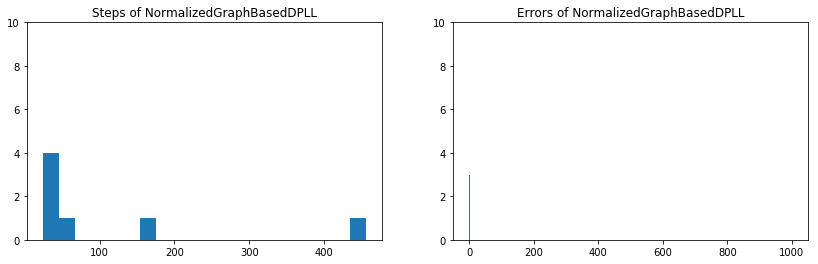

In [102]:
print_all(10, 1000, 50, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [02:38<00:00, 15.76s/it]
/Users/sebastianjaszczur/PycharmProjects/deepsat/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sebastianjaszczur/PycharmProjects/deepsat/venv/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sebastianjaszczur/PycharmProjects/deepsat/venv/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/sebastianjaszczur/PycharmProjects/deepsat/venv/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/sebastianjaszczur/PycharmProjects/deepsat/venv/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_s

Within 1000 steps solved 0 problems out of 10
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


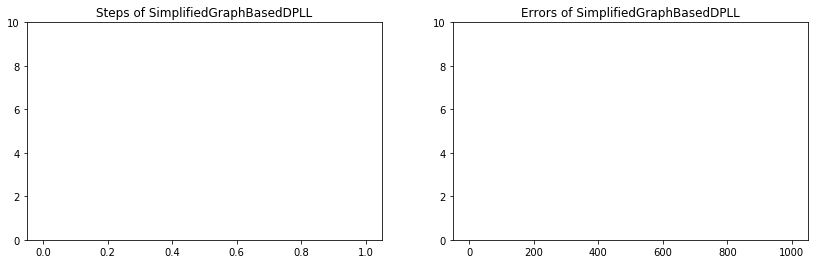

100%|██████████| 10/10 [04:19<00:00, 28.33s/it]


Within 1000 steps solved 3 problems out of 10
#Sats: 3; avg step: 54.00; stdev step: 11.43; avg error: 0.67; stdev error: 0.47


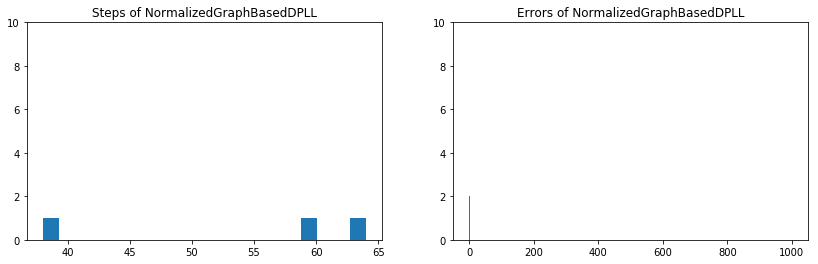

In [103]:
print_all(10, 1000, 70, light=True)